# 

In [1]:
from typing import Optional
import numpy as np

import gymnasium as gym
import simpy
from collections import namedtuple
gym.__version__

'1.2.2'

# Scenario

Guidelines how the shop will behave:
* The shop is tiny, only 2 operators
* 2 machines making 2 different products
* Making 2 different products:
  * Prod 1:
    * Mono step, only need machine 1
    * Cycle time = 3
    * Sell Value = 2
  * Prod 2:
    * Multi step, Machine 1 + 2 in that order 
    * Cycle time = 10 (M1) + 15 (M2)
    * Sell Value = 20
* Storages:
  * All storage have an inside capacity
  * outside is subject to lost products at night (loss define by 10% per unit per cycle time)
* Raw product to be ordered
  * Lead time = 3 UOT per order
  * Initial Stock = 10
  * Purchase price = 1
* Selling / profit
  * Everything that is available to be sold will be sold every 6 unit steps

In [2]:
Action = namedtuple('Action', [
    'current_batch',
    'force_current_batch', 
    'next_batch',
    'ranking_next',
    'order_raw_prod'
])

In [43]:
import gymnasium as gym
import simpy
import numpy as np


class ShopEnv(gym.Env):
    def __init__(self,
                 operatorcounts: int = 2,
                 machine_count: int = 2,
                 product_count: int = 2,
                 step: int = 1, #Hour
                 duration_max = 7 # Days
                ):
        self.operatorcounts = operatorcounts
        self.product_count = product_count
        self.machine_count = machine_count
        
        self.prod_assignment = np.zeros((self.product_count, self.machine_count))
        # Prod A only needs machine 1 for 3 unit of time (in minutes)
        self.prod_assignment[0, 0] = 3
        self.prod_assignment[0, 1] = 0
        # Prod B needs machine 1 for 10 unit of time, and 15 for machine 2 (in minutes)
        self.prod_assignment[1, 0] = 10
        self.prod_assignment[1, 1] = 15
        self.duration_max = duration_max

        self.prod_dict = {'0': {'Name': 'A', 'Cost': 3},
                          '1': {'Name': 'B', 'Cost': 20},
                          }

        # Where products need to go
        # Intermediary stock
        self.to_stock_prod = np.zeros((self.product_count, self.machine_count))
        self.to_stock_prod[0,0] = 0
        self.to_stock_prod[0,1] = 0
        # Prod B needs machine 1 for 10 unit of time, and 15 for machine 2 (in minutes)
        self.to_stock_prod[1,0] = 1
        self.to_stock_prod[1,1] = 0

        # Selling Stock
        self.to_sell_prod = np.zeros((self.product_count, self.machine_count))
        self.to_sell_prod[0,0] = 1
        self.to_sell_prod[0,1] = 0
        # Prod B needs machine 1 for 10 unit of time, and 15 for machine 2 (in minutes)
        self.to_sell_prod[1,0] = 0
        self.to_sell_prod[1,1] = 1
        
        self.pending_raw = 0
        
        self.observation_space = gym.spaces.Dict(
            {

                # Stocks 
                "stockraw_used": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
                "stockraw_free": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
                "stockint_used": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
                "stockint_free": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
                "stock2sell_used": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),
                "stock2sell_free": gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32),

                # What is in progress and how many to do next
                'current_batch_remaining': gym.spaces.Box(low=0, high=100, shape=(self.product_count, self.machine_count)),
                'next_batch': gym.spaces.Box(low=0, high=100, shape=(self.product_count, self.machine_count)),
                'ranking_next': gym.spaces.Box(low=np.zeros((self.product_count, self.machine_count)),
                                               high=np.ones((self.product_count, self.machine_count)), dtype=np.float32),

                # How does the staffing look like
                "count_operators_busy" : gym.spaces.Box(low=0, high=self.operatorcounts),
                "count_operators_free" : gym.spaces.Box(low=0, high=self.operatorcounts),

                # Where is made what with the cycle time
                "prod_assignment": gym.spaces.Box(low=0, high=500, shape=(self.product_count, self.machine_count), dtype=np.float32),

                # Pending Reception
                "pending_reception": gym.spaces.Box(low=0, high=1000),

                # Time of day
                "timeday": gym.spaces.Box(low=0, high=23)
            }
        )

        self._make_simpy_env()
        
        self.action_space = gym.spaces.Dict({
            # Allows to propose an alternative campaign size remaining
            'current_batch': gym.spaces.Box(low=0, high=100, shape=(self.product_count, self.machine_count)),
            # Enforce the campaign
            'force_current_batch': gym.spaces.MultiBinary((self.product_count, self.machine_count)),
            # Next Campaign batch size
            'next_batch': gym.spaces.Box(low=0, high=100, shape=(self.product_count, self.machine_count)),
            # Ranking for which products are active, higher better
            'ranking_next': gym.spaces.Box(low=np.zeros((self.product_count, self.machine_count)),
                                           high=np.ones((self.product_count, self.machine_count)), dtype=np.float32),
            # Do we need to order anything
            'order_raw_prod': gym.spaces.Box(low=0, high=100)
        })

        self.current_batch = np.zeros((self.product_count, self.machine_count))
        self.force_current_batch = np.zeros((self.product_count, self.machine_count))
        self.next_batch = np.zeros((self.product_count, self.machine_count))
        self.ranking_next = np.zeros((self.product_count, self.machine_count))

        # Unit of time for each step
        self.step_size = step # Decisions are made every hour
        self.episode_end = 7 * 24 # End after 7 days
        self.salesrewards = 0

        self.prod_log = np.zeros((self.product_count, self.machine_count))
        self.sell_log = np.zeros(self.product_count)

    def _make_simpy_env(self):
        self.shopsim = simpy.Environment()
        
        self.operators = simpy.Resource(self.shopsim, capacity=self.operatorcounts)
        
        self.stockraw = simpy.Container(self.shopsim, capacity=100, init=10)
        
        self.stockint = simpy.FilterStore(self.shopsim, capacity=50)
        self.stocksell = simpy.FilterStore(self.shopsim, capacity=50)

        for machine_num in range(self.machine_count):
            setattr(self, f'machine_{machine_num}', simpy.Resource(self.shopsim, capacity=1))  

        self.now_sim = 0

        self.shopsim.process(self.steal_product_at_night())
        self.shopsim.process(self.sell_products())
        self.shopsim.process(self.get_operators_to_work())
    
    
    def _get_obs(self):
        return {"stockraw_used": float(self.stockraw.level),
                "stockraw_free": float(self.stockraw.capacity - self.stockraw.level),
                "stockint_used": float(len(self.stockint.items)),
                "stockint_free": float(self.stockint.capacity - len(self.stockint.items)),
                "stock2sell_used": float(len(self.stocksell.items)),
                "stock2sell_free": float(self.stocksell.capacity - len(self.stocksell.items)),
                
                "current_batch_remaining": self.current_batch,
                "next_batch" : self.next_batch,
                "ranking_next": self.ranking_next,
                
                "count_operators_busy": float(self.operators.count),
                "count_operators_free": float(self.operators.capacity-self.operators.count),
                "prod_assignment": self.prod_assignment,
                "pending_reception": float(self.pending_raw),

                "timeday": float(self.shopsim.now % 24)
                
               }

    def _get_info(self):
        # Only for debugging purpose
        return {
            "production_log": self.prod_log,
            "sell_log": self.sell_log
        }

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self._make_simpy_env()
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def order_raw_product(self, qty):
        qty = int(qty)
        self.pending_raw += qty
        yield self.shopsim.timeout(3)
        roominstock = min(self.stockraw.capacity - self.stockraw.level, qty)
        if (roominstock>0) and (roominstock<=self.stockraw.capacity):
            yield self.stockraw.put(roominstock)
        self.pending_raw -= qty

    def steal_product_at_night(self, threshold_stock=10, day_hour=6, probability=.1):
        # at night for 12 hours each product not in the shop is subject to be stollen at a 10 % chance per cycle time
        while True:
            if self.shopsim.now % day_hour > day_hour/2:
                # print('We are in Night mode, get your products in !!')
                # Filter Stores
                for stock in (self.stockint, self.stocksell):
                    if len(stock.items) > threshold_stock:
                        at_risk = (np.random.random(len(stock.items)-threshold_stock) < probability).astype(int)
                        for product_index in at_risk:
                            if product_index == 1:
                                yield stock.get()
                                # print('product Stollen from Store')
                # Containers 
                for stock in (self.stockraw, ):
                    if stock.level > threshold_stock:
                        at_risk = (np.random.random(stock.level-threshold_stock) < probability).astype(int)
                        for product_index in at_risk:
                            if product_index == 1:
                                yield stock.get(1)
                                # print('product Stollen fron Container')
            else:
                # print('We are in Day mode')
                pass
            yield self.shopsim.timeout(self.step_size)

    def make_products(self, machine_j=0, prod_i=0, patience = 15):
        prod_made = 0
        cycletime = self.prod_assignment[prod_i, machine_j] #Minutes
        machine = getattr(self, f'machine_{machine_j}')

        # That needs to be improved / automated
        # if prod_i == 0:
        stockin = self.stockraw
        filterstore = False
        if prod_i == 1 and machine_j == 1:
            stockin = self.stockint
            filterstore = True
        
        if self.to_stock_prod[prod_i, machine_j] == 1:
            stockout = self.stockint
        if self.to_sell_prod[prod_i, machine_j] == 1:
            stockout = self.stocksell
        
        with self.operators.request() as op_req, machine.request() as machine_req:
            # Wait for both resources to be available
            yield op_req
            yield machine_req
            while prod_made < self.current_batch[prod_i, machine_j]:
                if filterstore:
                    # print(stockin.items , machine_j)
                    event = stockin.get(lambda x: x==str(prod_i))
                else:
                    event = stockin.get(1)

                timeout_event = self.shopsim.timeout(patience/60)

                result = yield event | timeout_event

                if event in result:
                    prod_made += 1
                    self.prod_log[prod_i, machine_j] +=1
                    yield stockout.put(str(prod_i))
                    # print(f'Just made a product {self.prod_dict.get(str(prod_i))['Name']} - Machine {machine_j}')
                    yield self.shopsim.timeout(cycletime/60)
                else:
                    # print(f'Operator Gave up after {patience} minutes weight at {self.shopsim.now} - Machine {machine_j}')
                    break
        if prod_made == self.current_batch[prod_i, machine_j]:          
            self.current_batch[prod_i, machine_j] = self.next_batch[prod_i, machine_j]
            self.next_batch[prod_i, machine_j] = 0

    def get_operators_to_work(self):
        while True:
            if self.current_batch.sum() == 0:
                # If no current task, pass next to current
                for i, j in np.ndindex(self.next_batch.shape):
                    if self.current_batch[i, j] == 0:
                        self.current_batch[i, j] = self.next_batch[i, j]
                        self.next_batch[i, j] = 0
            if self.operators.count <= self.operators.capacity:
                max_idx = np.argmax(self.ranking_next)
                i, j = np.unravel_index(max_idx, self.ranking_next.shape)
                self.ranking_next[i, j] = 0
                machine = getattr(self, f'machine_{j}')
                if (self.current_batch[i, j] > 0) and (machine.count==0) and (self.prod_assignment[i, j] != 0):
                    self.shopsim.process(self.make_products(prod_i=i, machine_j=j))
                
            # Can try an else: here
            yield self.shopsim.timeout(self.step_size/60)

    def sell_products(self, freq=1):
        while True:
            # print(self.stocksell.items)
            if self.shopsim.now % freq == 0:
                allprods = [x for x in self.stocksell.items]
                for prod in allprods:
                    sold = yield self.stocksell.get(lambda x: x==prod)
                    # print(f'Congrats, you just sold a product {self.prod_dict.get(prod)['Name']} - Value {self.prod_dict.get(prod)['Cost']}')
                    self.sell_log[int(prod)] +=1
                    self.salesrewards += self.prod_dict.get(prod)['Cost']
            yield self.shopsim.timeout(self.step_size)

    def step(self, action):
        # Does he want to enforce a new batch size:
        reward = 0
        truncated = False
        terminated = True if self.shopsim.now == self.duration_max*24 else False
        for i, j in np.ndindex(action.force_current_batch.shape):
            if action.force_current_batch[i,j]==1:
                self.current_batch[i,j] = action.current_batch[i,j]
                reward -= 1

        # We set what should be done next and with what urgency
        for i, j in np.ndindex(action.next_batch.shape):
            if self.prod_assignment[i, j] > 0:
                self.next_batch[i, j] = action.next_batch[i, j]
                self.ranking_next[i, j] = action.ranking_next[i, j]

        # We order raw product
        if action.order_raw_prod > 0:
            self.shopsim.process(self.order_raw_product(action.order_raw_prod))
            reward = reward - action.order_raw_prod * 1

        # Execute the Simpy
        self.now_sim += self.step_size
        self.shopsim.run(until=self.now_sim)

        reward += self.salesrewards
        self.salesrewards = 0
        
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

In [59]:
gym.register(
    id="TinyShop_env/Shop-v0",
    entry_point=ShopEnv,
    max_episode_steps=1*24,  # Prevent infinite episodes
)

In [60]:
env = gym.make("TinyShop_env/Shop-v0")

In [61]:
env.observation_space

Dict('count_operators_busy': Box(0.0, 2.0, (1,), float32), 'count_operators_free': Box(0.0, 2.0, (1,), float32), 'current_batch_remaining': Box(0.0, 100.0, (2, 2), float32), 'next_batch': Box(0.0, 100.0, (2, 2), float32), 'pending_reception': Box(0.0, 1000.0, (1,), float32), 'prod_assignment': Box(0.0, 500.0, (2, 2), float32), 'ranking_next': Box(0.0, 1.0, (2, 2), float32), 'stock2sell_free': Box(0.0, 100.0, (1,), float32), 'stock2sell_used': Box(0.0, 100.0, (1,), float32), 'stockint_free': Box(0.0, 100.0, (1,), float32), 'stockint_used': Box(0.0, 100.0, (1,), float32), 'stockraw_free': Box(0.0, 100.0, (1,), float32), 'stockraw_used': Box(0.0, 100.0, (1,), float32), 'timeday': Box(0.0, 23.0, (1,), float32))

In [62]:
env.action_space

Dict('current_batch': Box(0.0, 100.0, (2, 2), float32), 'force_current_batch': MultiBinary((2, 2)), 'next_batch': Box(0.0, 100.0, (2, 2), float32), 'order_raw_prod': Box(0.0, 100.0, (1,), float32), 'ranking_next': Box(0.0, 1.0, (2, 2), float32))

In [63]:
env.reset()

({'stockraw_used': 10.0,
  'stockraw_free': 90.0,
  'stockint_used': 0.0,
  'stockint_free': 50.0,
  'stock2sell_used': 0.0,
  'stock2sell_free': 50.0,
  'current_batch_remaining': array([[0., 0.],
         [0., 0.]]),
  'next_batch': array([[0., 0.],
         [0., 0.]]),
  'ranking_next': array([[0., 0.],
         [0., 0.]]),
  'count_operators_busy': 0.0,
  'count_operators_free': 2.0,
  'prod_assignment': array([[ 3.,  0.],
         [10., 15.]]),
  'pending_reception': 0.0,
  'timeday': 0.0},
 {'production_log': array([[0., 0.],
         [0., 0.]]),
  'sell_log': array([0., 0.])})

In [51]:
action = Action(
    current_batch=np.array([[5, 0],
                            [5, 5]]),
    force_current_batch=np.array([[0, 0],
                                  [0, 0]]),
    next_batch=np.array([[1, 0],
                         [5, 5]]),
    ranking_next=np.array([[0.1, 0],
                           [0.3, 0.01]]),
    order_raw_prod=10
)
# Take a step
observation, reward, terminated, truncated, info = env.step(action)
print("Reward:", reward)
print("New observation:", observation)

Reward: 10
New observation: {'stockraw_used': 4.0, 'stockraw_free': 96.0, 'stockint_used': 0.0, 'stockint_free': 50.0, 'stock2sell_used': 0.0, 'stock2sell_free': 50.0, 'current_batch_remaining': array([[0., 0.],
       [0., 5.]]), 'next_batch': array([[1., 0.],
       [5., 5.]]), 'ranking_next': array([[0., 0.],
       [0., 0.]]), 'count_operators_busy': 0.0, 'count_operators_free': 2.0, 'prod_assignment': array([[ 3.,  0.],
       [10., 15.]]), 'pending_reception': 20.0, 'timeday': 3.0}


In [52]:
action


Action(current_batch=array([[5, 0],
       [5, 5]]), force_current_batch=array([[0, 0],
       [0, 0]]), next_batch=array([[1, 0],
       [5, 5]]), ranking_next=array([[0.1 , 0.  ],
       [0.3 , 0.01]]), order_raw_prod=10)

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Normal
from typing import Dict, List, Tuple
from collections import namedtuple
import gymnasium as gym

# Définition du namedtuple Action
Action = namedtuple('Action', [
    'current_batch',
    'force_current_batch', 
    'next_batch',
    'ranking_next',
    'order_raw_prod'
])


class ActorCriticNetwork(nn.Module):
    """Réseau Actor-Critic pour PPO avec actions continues"""
    def __init__(self, state_dim, action_components, hidden_dims=[256, 256, 128]):
        super(ActorCriticNetwork, self).__init__()
        
        # Shared feature extractor
        layers = []
        prev_dim = state_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(hidden_dim))
            prev_dim = hidden_dim
        
        self.shared_network = nn.Sequential(*layers)
        
        # Actor heads (une tête par composant d'action) - Toutes continues
        self.action_components = action_components
        self.actor_heads_mean = nn.ModuleDict()
        self.actor_heads_logstd = nn.ModuleDict()
        
        for name, dim in action_components.items():
            self.actor_heads_mean[name] = nn.Linear(prev_dim, dim)
            self.actor_heads_logstd[name] = nn.Linear(prev_dim, dim)
        
        # Critic head
        self.critic = nn.Linear(prev_dim, 1)
    
    def forward(self, state):
        features = self.shared_network(state)
        
        # Actor outputs (distributions gaussiennes pour toutes les actions)
        actions_mean = {}
        actions_logstd = {}
        
        for name in self.action_components.keys():
            actions_mean[name] = self.actor_heads_mean[name](features)
            actions_logstd[name] = self.actor_heads_logstd[name](features)
        
        # Critic output
        value = self.critic(features)
        
        return actions_mean, actions_logstd, value


dqn = ActorCriticNetwork(3, {'A':1, 'B': 3})
dqn.action_components

{'A': 1, 'B': 3}

In [71]:
class RolloutBuffer:
    """Buffer pour stocker les trajectoires complètes"""
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
    
    def add(self, state, action, log_prob, reward, value, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
    
    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.log_probs.clear()
        self.rewards.clear()
        self.values.clear()
        self.dones.clear()
    
    def get(self):
        return (
            np.array(self.states),
            self.actions,
            np.array(self.log_probs),
            np.array(self.rewards),
            np.array(self.values),
            np.array(self.dones)
        )
    
    def __len__(self):
        return len(self.states)

In [74]:

class ShopPPOAgent:
    """Agent PPO pour l'environnement ShopEnv avec actions continues"""
    def __init__(
        self,
        env,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_epsilon=0.2,
        value_coef=0.5,
        entropy_coef=0.01,
        max_grad_norm=0.5,
        ppo_epochs=10,
        batch_size=64,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.env = env
        self.device = device
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_epsilon = clip_epsilon
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
        self.ppo_epochs = ppo_epochs
        self.batch_size = batch_size
        
        # Dimensions
        self.state_dim = self._get_state_dim()
        self.action_components = self._get_action_components()
        
        # Réseau Actor-Critic
        self.policy = ActorCriticNetwork(
            self.state_dim, 
            self.action_components
        ).to(device)
        
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        # Buffer
        self.rollout_buffer = RolloutBuffer()
        
        # Métriques
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.entropy_losses = []
    
    def _get_state_dim(self):
        """Calcule la dimension de l'état"""
        obs, _ = self.env.reset()
        flat_state = self._flatten_observation(obs)
        return len(flat_state)
    
    def _get_action_components(self):
        """Retourne les dimensions pour chaque composant d'action"""
        pc = self.env.product_count
        mc = self.env.machine_count
        
        return {
            'current_batch': pc * mc,
            'force_current_batch': pc * mc,
            'next_batch': pc * mc,
            'ranking_next': pc * mc,
            'order_raw_prod': 1
        }
    
    def _flatten_observation(self, obs: Dict) -> np.ndarray:
        """Aplatit l'observation en un vecteur"""
        flat_parts = []
        
        # Scalaires
        for key in ['stockraw_used', 'stockraw_free', 'stockint_used', 
                    'stockint_free', 'stock2sell_used', 'stock2sell_free',
                    'count_operators_busy', 'count_operators_free', 
                    'pending_reception', 'timeday']:
            flat_parts.append([float(obs[key])])
        
        # Matrices
        for key in ['current_batch_remaining', 'next_batch', 'ranking_next', 'prod_assignment']:
            flat_parts.append(obs[key].flatten().astype(float))
        
        return np.concatenate(flat_parts)
    
    def select_action(self, state: np.ndarray, training=True):
        """Sélectionne une action selon la politique"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            actions_mean, actions_logstd, value = self.policy(state_tensor)
        
        log_probs = []
        pc = self.env.product_count
        mc = self.env.machine_count
        
        # current_batch - continu 0-100, converti en int
        mean = actions_mean['current_batch'].squeeze()
        std = torch.exp(actions_logstd['current_batch'].squeeze()).clamp(0.1, 10.0)
        dist = Normal(mean, std)
        sampled = dist.sample() if training else mean
        sampled = torch.clamp(sampled, 0.0, 100.0)
        current_batch = sampled.view(pc, mc).cpu().numpy().astype(np.float32)
        if training:
            log_probs.append(dist.log_prob(sampled).sum())
        
        # force_current_batch - continu 0-1, puis converti en binaire avec seuil 0.5
        mean = torch.sigmoid(actions_mean['force_current_batch'].squeeze())
        std = torch.exp(actions_logstd['force_current_batch'].squeeze()).clamp(0.01, 0.5)
        dist = Normal(mean, std)
        sampled = dist.sample() if training else mean
        sampled = torch.clamp(sampled, 0.0, 1.0)
        force_current_batch = (sampled > 0.5).float().view(pc, mc).cpu().numpy().astype(np.float32)
        if training:
            log_probs.append(dist.log_prob(sampled).sum())
        
        # next_batch - continu 0-100
        mean = actions_mean['next_batch'].squeeze()
        std = torch.exp(actions_logstd['next_batch'].squeeze()).clamp(0.1, 10.0)
        dist = Normal(mean, std)
        sampled = dist.sample() if training else mean
        sampled = torch.clamp(sampled, 0.0, 100.0)
        next_batch = sampled.view(pc, mc).cpu().numpy().astype(np.float32)
        if training:
            log_probs.append(dist.log_prob(sampled).sum())
        
        # ranking_next - continu 0-1
        mean = torch.sigmoid(actions_mean['ranking_next'].squeeze())
        std = torch.exp(actions_logstd['ranking_next'].squeeze()).clamp(0.01, 0.3)
        dist = Normal(mean, std)
        sampled = dist.sample() if training else mean
        sampled = torch.clamp(sampled, 0.0, 1.0)
        ranking_next = sampled.view(pc, mc).cpu().numpy().astype(np.float32)
        if training:
            log_probs.append(dist.log_prob(sampled).sum())
        
        # order_raw_prod - continu 0-100
        mean = actions_mean['order_raw_prod'].squeeze()
        std = torch.exp(actions_logstd['order_raw_prod'].squeeze()).clamp(0.1, 10.0)
        dist = Normal(mean, std)
        sampled = dist.sample() if training else mean
        sampled = torch.clamp(sampled, 0.0, 100.0)
        order_raw_prod = float(sampled.item())
        if training:
            log_probs.append(dist.log_prob(sampled))
        
        total_log_prob = sum(log_probs).item() if training else 0
        
        # Créer le namedtuple Action
        action = Action(
            current_batch=current_batch,
            force_current_batch=force_current_batch,
            next_batch=next_batch,
            ranking_next=ranking_next,
            order_raw_prod=order_raw_prod
        )
        
        return action, total_log_prob, value.item()
    
    def compute_gae(self, rewards, values, dones, next_value):
        """Calcule les avantages avec GAE"""
        advantages = np.zeros_like(rewards)
        last_gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value_t = next_value
            else:
                next_value_t = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value_t * (1 - dones[t]) - values[t]
            advantages[t] = last_gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * last_gae
        
        returns = advantages + values
        return advantages, returns
    
    def update(self):
        """Met à jour la politique avec PPO"""
        if len(self.rollout_buffer) == 0:
            return
        
        # Récupérer les données du buffer
        states, actions_list, old_log_probs, rewards, values, dones = self.rollout_buffer.get()
        
        # Calculer les avantages
        with torch.no_grad():
            last_state = torch.FloatTensor(states[-1]).unsqueeze(0).to(self.device)
            _, _, next_value = self.policy(last_state)
            next_value = next_value.item()
        
        advantages, returns = self.compute_gae(rewards, values, dones, next_value)
        
        # Normaliser les avantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Convertir en tenseurs
        states_tensor = torch.FloatTensor(states).to(self.device)
        old_log_probs_tensor = torch.FloatTensor(old_log_probs).to(self.device)
        advantages_tensor = torch.FloatTensor(advantages).to(self.device)
        returns_tensor = torch.FloatTensor(returns).to(self.device)
        
        # Convertir les actions en tenseurs
        pc = self.env.product_count
        mc = self.env.machine_count
        
        actions_tensors = {
            'current_batch': [],
            'force_current_batch': [],
            'next_batch': [],
            'ranking_next': [],
            'order_raw_prod': []
        }
        
        for action in actions_list:
            actions_tensors['current_batch'].append(action.current_batch.flatten())
            actions_tensors['force_current_batch'].append(action.force_current_batch.flatten())
            actions_tensors['next_batch'].append(action.next_batch.flatten())
            actions_tensors['ranking_next'].append(action.ranking_next.flatten())
            actions_tensors['order_raw_prod'].append([action.order_raw_prod])
        
        for key in actions_tensors:
            actions_tensors[key] = torch.FloatTensor(np.array(actions_tensors[key])).to(self.device)
        
        # Epochs PPO
        for epoch in range(self.ppo_epochs):
            # Mini-batches
            indices = np.random.permutation(len(states))
            
            for start in range(0, len(states), self.batch_size):
                end = min(start + self.batch_size, len(states))
                batch_idx = indices[start:end]
                
                batch_states = states_tensor[batch_idx]
                batch_old_log_probs = old_log_probs_tensor[batch_idx]
                batch_advantages = advantages_tensor[batch_idx]
                batch_returns = returns_tensor[batch_idx]
                
                # Actions du batch
                batch_actions = {}
                for key in actions_tensors:
                    batch_actions[key] = actions_tensors[key][batch_idx]
                
                # Forward pass
                actions_mean, actions_logstd, values_pred = self.policy(batch_states)
                
                # Recalculer les log_probs pour le batch
                log_probs_new = []
                entropy = []
                
                for key in ['current_batch', 'force_current_batch', 'next_batch', 'ranking_next', 'order_raw_prod']:
                    mean = actions_mean[key]
                    std = torch.exp(actions_logstd[key]).clamp(0.01, 10.0)
                    
                    # Appliquer sigmoid pour force_current_batch et ranking_next
                    if key in ['force_current_batch', 'ranking_next']:
                        mean = torch.sigmoid(mean)
                        std = std.clamp(0.01, 0.5)
                    
                    dist = Normal(mean, std)
                    log_probs_new.append(dist.log_prob(batch_actions[key]).sum(dim=1))
                    entropy.append(dist.entropy().sum(dim=1))
                
                log_probs_new = sum(log_probs_new)
                entropy_loss = sum(entropy).mean()
                
                # Actor loss (PPO clip)
                ratio = torch.exp(log_probs_new - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Critic loss
                values_pred = values_pred.squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_returns)
                
                # Total loss
                loss = actor_loss + self.value_coef * critic_loss - self.entropy_coef * entropy_loss
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.optimizer.step()
                
                # Enregistrer les métriques
                self.actor_losses.append(actor_loss.item())
                self.critic_losses.append(critic_loss.item())
                self.entropy_losses.append(entropy_loss.item())
        
        # Vider le buffer
        self.rollout_buffer.clear()
    
    def train(self, num_episodes=1000, max_steps=200, update_frequency=2048, verbose=True):
        """Entraîne l'agent"""
        print(f"Démarrage de l'entraînement PPO sur {self.device}")
        print(f"State dim: {self.state_dim}")
        print(f"Action components: {self.action_components}")
        
        total_steps = 0
        
        for episode in range(num_episodes):
            obs, _ = self.env.reset()
            state = self._flatten_observation(obs)
            episode_reward = 0
            
            for step in range(max_steps):
                # Sélectionner et exécuter une action
                action, log_prob, value = self.select_action(state, training=True)
                
                try:
                    next_obs, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated
                    
                    next_state = self._flatten_observation(next_obs)
                    
                    # Stocker dans le buffer
                    self.rollout_buffer.add(state, action, log_prob, reward, value, float(done))
                    
                    episode_reward += reward
                    state = next_state
                    total_steps += 1
                    
                    # Mettre à jour la politique
                    if total_steps % update_frequency == 0:
                        self.update()
                    
                    if done:
                        break
                        
                except Exception as e:
                    print(f"Erreur pendant l'épisode {episode}, step {step}: {e}")
                    import traceback
                    traceback.print_exc()
                    break
            
            # Enregistrer les métriques
            self.episode_rewards.append(episode_reward)
            
            # Affichage
            if verbose and (episode + 1) % 10 == 0:
                avg_reward = np.mean(self.episode_rewards[-10:])
                avg_actor_loss = np.mean(self.actor_losses[-100:]) if self.actor_losses else 0
                avg_critic_loss = np.mean(self.critic_losses[-100:]) if self.critic_losses else 0
                avg_entropy = np.mean(self.entropy_losses[-100:]) if self.entropy_losses else 0
                print(f"Episode {episode + 1}/{num_episodes} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Actor Loss: {avg_actor_loss:.4f} | "
                      f"Critic Loss: {avg_critic_loss:.4f} | "
                      f"Entropy: {avg_entropy:.4f}")
        
        # Dernière mise à jour
        if len(self.rollout_buffer) > 0:
            self.update()
        
        print("Entraînement terminé!")
    
    def save(self, path='ppo_shop_model.pth'):
        """Sauvegarde le modèle"""
        torch.save({
            'policy': self.policy.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'episode_rewards': self.episode_rewards,
            'actor_losses': self.actor_losses,
            'critic_losses': self.critic_losses,
            'entropy_losses': self.entropy_losses
        }, path)
        print(f"Modèle sauvegardé à {path}")
    
    def load(self, path='ppo_shop_model.pth'):
        """Charge le modèle"""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy.load_state_dict(checkpoint['policy'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.episode_rewards = checkpoint['episode_rewards']
        self.actor_losses = checkpoint['actor_losses']
        self.critic_losses = checkpoint['critic_losses']
        self.entropy_losses = checkpoint.get('entropy_losses', [])
        print(f"Modèle chargé depuis {path}")



In [75]:
agent = ShopPPOAgent(env, learning_rate=3e-4, batch_size=64)

[1.00000000e+01 9.00000000e+01 0.00000000e+00 5.00000000e+01
 0.00000000e+00 5.00000000e+01 0.00000000e+00 2.00000000e+00
 2.93000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.69774914e-02 1.59804225e+00 0.00000000e+00
 0.00000000e+00 1.57507062e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.00000000e+00 0.00000000e+00
 1.00000000e+01 1.50000000e+01]


In [67]:

# Importer votre environnement
# from shop_env import ShopEnv

# Créer l'environnement
env = ShopEnv()

# Créer et entraîner l'agent
agent = ShopPPOAgent(env, learning_rate=3e-4, batch_size=64)
agent.train(num_episodes=500, max_steps=168, update_frequency=2048)

# Sauvegarder le modèle
# agent.save('ppo_shop_model.pth')



print("Code PPO prêt à l'emploi. Décommentez les lignes du main pour exécuter.")

Démarrage de l'entraînement PPO sur cuda
State dim: 26
Action components: {'current_batch': 4, 'force_current_batch': 4, 'next_batch': 4, 'ranking_next': 4, 'order_raw_prod': 1}
Episode 10/500 | Avg Reward: -336.05 | Actor Loss: 0.0000 | Critic Loss: 0.0000 | Entropy: 0.0000
Episode 20/500 | Avg Reward: -297.85 | Actor Loss: 0.2566 | Critic Loss: 320.4166 | Entropy: 39.3000
Episode 30/500 | Avg Reward: -457.95 | Actor Loss: 0.2461 | Critic Loss: 4534.7840 | Entropy: 36.3622
Episode 40/500 | Avg Reward: -227.84 | Actor Loss: 377859.2426 | Critic Loss: 4650.4070 | Entropy: 31.6430
Erreur pendant l'épisode 48, step 127: Expected parameter loc (Tensor of shape (64, 4)) of distribution Normal(loc: torch.Size([64, 4]), scale: torch.Size([64, 4])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [

Traceback (most recent call last):
  File "/tmp/ipykernel_80026/3736982337.py", line 324, in train
    self.update()
    ~~~~~~~~~~~^^
  File "/tmp/ipykernel_80026/3736982337.py", line 258, in update
    dist = Normal(mean, std)
  File "/home/laurent/miniconda3/envs/deeprl1/lib/python3.14/site-packages/torch/distributions/normal.py", line 66, in __init__
    super().__init__(batch_shape, validate_args=validate_args)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/laurent/miniconda3/envs/deeprl1/lib/python3.14/site-packages/torch/distributions/distribution.py", line 77, in __init__
    raise ValueError(
    ...<5 lines>...
    )
ValueError: Expected parameter loc (Tensor of shape (64, 4)) of distribution Normal(loc: torch.Size([64, 4]), scale: torch.Size([64, 4])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan

ValueError: Expected parameter loc (Tensor of shape (4,)) of distribution Normal(loc: torch.Size([4]), scale: torch.Size([4])) to satisfy the constraint Real(), but found invalid values:
tensor([nan, nan, nan, nan], device='cuda:0')

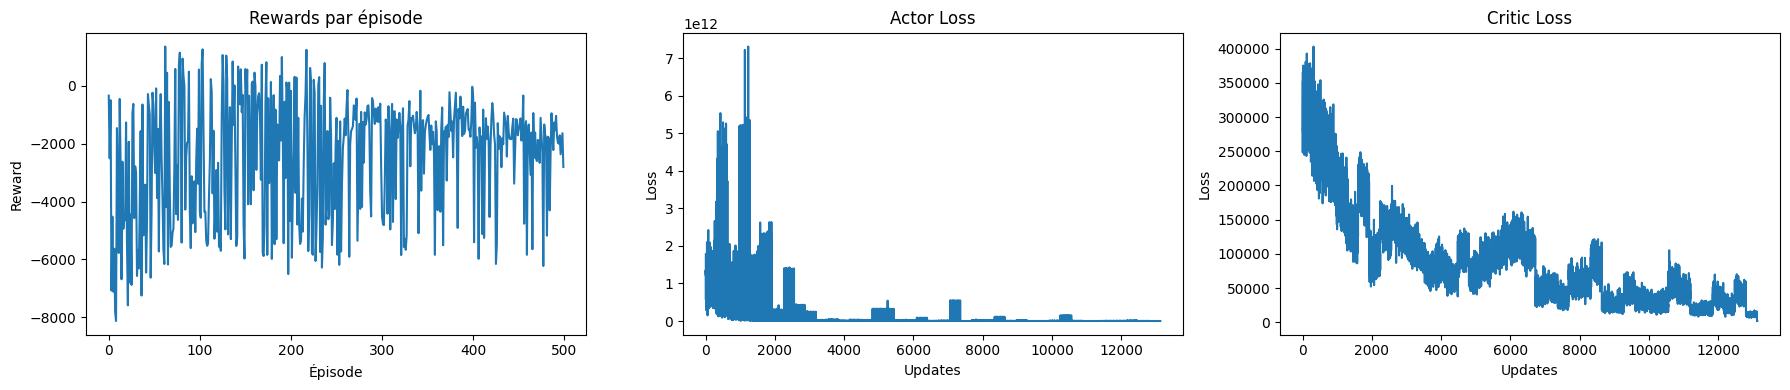

In [15]:
# Visualiser les résultats
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(agent.episode_rewards)
axes[0, 0].set_title('Rewards par épisode')
axes[0, 0].set_xlabel('Épisode')
axes[0, 0].set_ylabel('Reward')

axes[0, 1].plot(agent.actor_losses)
axes[0, 1].set_title('Actor Loss')
axes[0, 1].set_xlabel('Updates')
axes[0, 1].set_ylabel('Loss')

axes[1, 0].plot(agent.critic_losses)
axes[1, 0].set_title('Critic Loss')
axes[1, 0].set_xlabel('Updates')
axes[1, 0].set_ylabel('Loss')

axes[1, 1].plot(agent.entropy_losses)
axes[1, 1].set_title('Entropy')
axes[1, 1].set_xlabel('Updates')
axes[1, 1].set_ylabel('Entropy')

plt.tight_layout()
# plt.savefig('ppo_training_results.png')
plt.show()